In [1]:
%matplotlib notebook
#!/usr/bin/env python
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cufflinks
import plotly.plotly as py
py.sign_in('revilo222', 'qnGBeolE0CtdzjEajfql')

import matplotlib as mpl
mpl.rcParams['font.size'] = 8.
mpl.rcParams['font.family'] = 'serif'

golden_ratio  = (np.sqrt(5) - 1.0) / 2.0  # because it looks good
figWidth = 3.37
mpl.rcParams['figure.figsize'] = figWidth, figWidth * golden_ratio

PlotlyError: Sign in failed.

In [2]:
df = pd.read_csv('2d_progression.dat', sep='\s+', header=None)

In [3]:
# from http://stackoverflow.com/questions/17577587/matplotlib-2d-graph-with-interpolation
import scipy.interpolate
import matplotlib.pyplot as plt


def normal_interp(x, y, a, xi, yi):
    rbf = scipy.interpolate.Rbf(x, y, a)
    ai = rbf(xi, yi)
    return ai, rbf

def rescaled_interp(x, y, a, xi, yi):
    a_rescaled = (a - a.min()) / a.ptp()
    ai, interp = normal_interp(x, y, a_rescaled, xi, yi)
    ai = a.ptp() * ai + a.min()
    return ai, rbf

def plot(x, y, a, ai, title):
    fig, ax = plt.subplots()

    im = ax.imshow(ai.T, origin='lower',
                   extent=[x.min(), x.max(), y.min(), y.max()])
    #ax.scatter(x, y, c=a)

    ax.set(xlabel='Mg charge state', ylabel='O charge state', title=title)
    fig.colorbar(im)


In [4]:
def bragg_2d_heatmap(df, peak_hkl_string, mode = 'log', norm = True):
    """
    Make a heatmap of the Bragg peak intensity (normalized to 200) as a function of the number of
    2p electrons in Mg and O.
    
    Returns a 2d interpolation function.
    """
    hkl_map = {'111': 2, '200': 3} # map hkls into rows of the data file 2d_progression.dat
    mg_ionization, o_ionization = np.array(df.iloc[:2, :])
    x = mg_ionization
    y = o_ionization
    progression = np.array(df.iloc[hkl_map[peak_hkl_string], :])
    ref = np.array(df.iloc[hkl_map['200'], :])
    if norm:
        a = progression/ref#/progression.max())
    else:
        a = progression
    xi, yi = np.mgrid[x.min():x.max():500j, y.min():y.max():500j]

    a_orig, interp = normal_interp(x, y, a, xi, yi)
    #a_rescale = rescaled_interp(x, y, a, xi, yi)
    if mode == 'log':
        plot(x, y, np.log(a), np.log(a_orig), ' $\log(I_{%s}/I_{200})$ vs. Mg and O 2p ionization' % peak_hkl_string)
    elif mode == 'linear':
        plot(x, y, a, a_orig, ' $\I_{%s}/I_{200}$ vs. Mg and O 2p ionization' % peak_hkl_string)
    #plot(x, y, a, a_rescale, 'Rescaled')
    plt.show()
    return interp

Note that we start ionizing the O with only 4 (instead of 6) valence electrons. This corresponds to SCFLY's zero-temperature limit. We can expect it to be inaccurate for temperatures on the order of 1 eV or below.

<IPython.core.display.Javascript object>


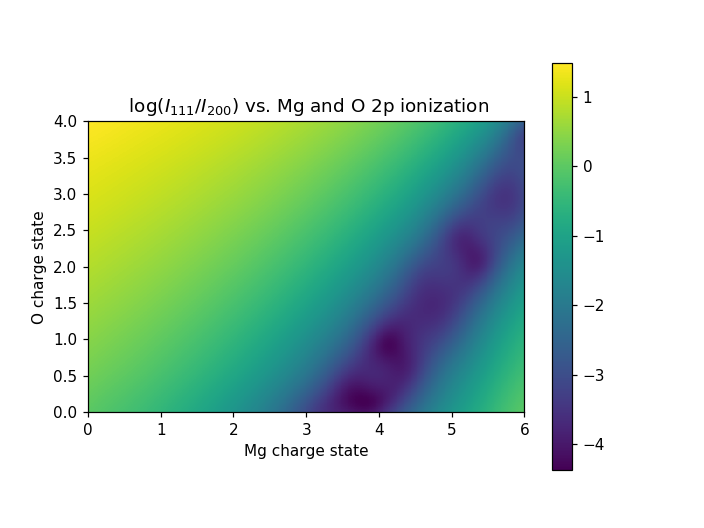

In [5]:
interp2d = bragg_2d_heatmap(df, '111')

<IPython.core.display.Javascript object>


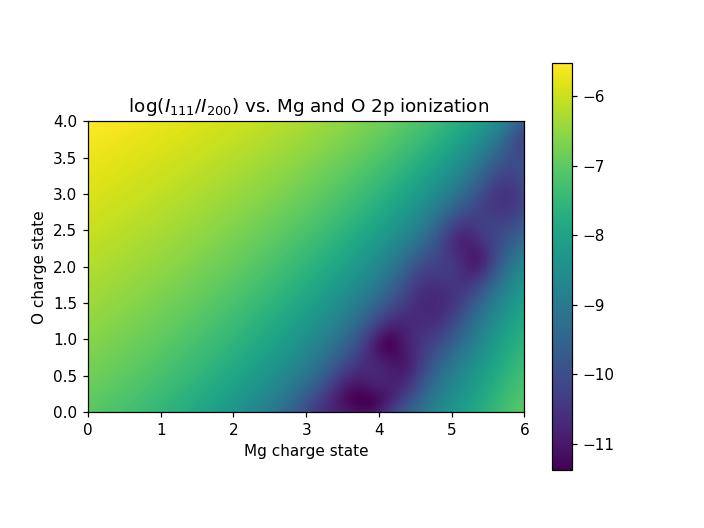

In [6]:
interp2d = bragg_2d_heatmap(df, '111', norm=False)

<IPython.core.display.Javascript object>


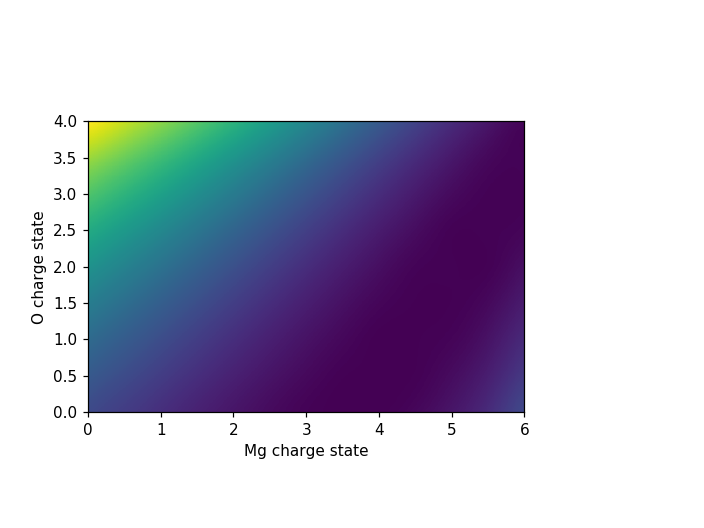

In [7]:
interp2d = bragg_2d_heatmap(df, '111', mode = 'linear')

Same thing with the full domain of ionization levels (instead of just the ones accessible in SCFLY):

<IPython.core.display.Javascript object>


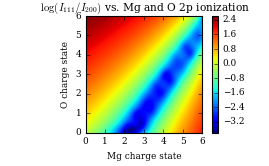

In [16]:
df2 = pd.read_csv('2d_progression_full.dat', sep='\s+', header=None)
bragg_2d_heatmap(df2, '111')
plt.gcf().subplots_adjust(bottom=0.2, left = 0.15)

In [17]:
plt.savefig('2d_progression.png', dpi = 300, bbox_inches='tight')

I've 'cleaned up' the file from Sam Vinko to include only the rows of intensity values. 

In [9]:
pulse = pd.read_csv('hv_file_intensities', sep = '\s+', header = None)

In [88]:
times = pd.read_csv('hv_file_times', sep = '\s+', header = None)
intensity = pulse.mean(axis = 1)
iframe = intensity.to_frame()
#iframe.index = times
iframe/= iframe.sum()

In [13]:
times.max() # 120 fs

0    1.200000e-13
dtype: float64

## Note on data import:

The populations files from Sam have had the second line deleted and the '#' character from the first one removed.

In [14]:
def get_charge_states(atom):
    """
    given mg or o, return a 1d of charge states for all time points.
    """
    charge_weights = np.array(atom.columns, dtype = int)
    charge_states = (atom * charge_weights).sum(axis = 1)
    return charge_states

def i111_ratio_from_population_file(path, label = None):
    populations = pd.read_csv(path, sep = '\s+') * 2
    o = populations[pd.Index(['0.1', '1.1', '2.1', '3.1', '4.1', '5.1', '6.1',
       '7.1', '8.1'], dtype='object')]
    o.columns = pd.Index(['0', '1', '2', '3', '4', '5', '6', '7', '8'],
          dtype='object')

    mg = populations[pd.Index(['0', '1', '2', '3', '4', '5', '6', '7', '8',
           '9', '10', '11', '12'],
          dtype='object')]
    mg = populations[pd.Index(['2', '3', '4', '5', '6', '7', '8',
           '9', '10', '11', '12'],
          dtype='object')]
    mg.columns = pd.Index(['0', '1', '2', '3', '4', '5', '6', '7', '8',
           '9', '10'],
          dtype='object')

    charge_o = get_charge_states(o).to_frame()
    charge_mg = get_charge_states(mg).to_frame()
    charge_o.index = times
    charge_mg.index = times
    
    if label is None:
        label = path
        
    plt.plot(interp2d(charge_mg, charge_o), label = label)
    #plt.legend(loc=11, bbox_to_anchor=(0.5, -0.1), ncol=2)
    plt.legend(bbox_to_anchor=(-.15, 1), loc=2, borderaxespad=1.)
    #plt.legend()

    
    profile = np.array(iframe).T
    return np.dot(profile, interp2d(charge_mg, charge_o))[0, 0]

### Here we set up the calculation of VASP 111/200 peak ratios vs. incident flux, using temperatures from SCFLY (instead of based on the DOS-derived specific heat expression)

In [15]:
def temperature(path, label = None):
    return pd.read_csv(path, sep = '\s+')[pd.Index(['Te'], dtype='object')]

In [134]:
pulse_duration = 45e-15
intensities = np.array(list(np.array(pd.read_csv('intensity_grid.dat', sep='\s+', header=None)[1]) * pulse_duration))

array([ 19933.65 ,  13085.55 ,   8590.5  ,   5639.4  ,   3702.06 ,
         2430.315,   1595.43 ,   1047.33 ,    687.555,    451.35 ])

In [17]:
populations = ['populations/pp.i%s' % i for i in range(1, 11)]

In [ ]:
def correct_temperature(temp):
    temp.iloc[0] = temp.iloc[1]
    temp -= temp.iloc[0]
    return temp

In [24]:
temperatures = [correct_temperature(temperature(p)) for p in populations]

In [19]:
avogadro = 6.022 * 10**23
to_ev = 6.24e18
peratom = lambda I, mu, M, rho: I * M / (mu * rho * avogadro)
to_ev * 2.4e-17

def flux_to_ev(flux):
    return peratom(flux, .015, 40.3, 3.6) * to_ev

def ev_to_flux(ev):
    return ev / (peratom(1., .015, 40.3, 3.6) * to_ev)

In [135]:
intensities_ev = flux_to_ev(intensities)

Sanity check: plot temperature progressions for all SCFLY datasets:

<IPython.core.display.Javascript object>


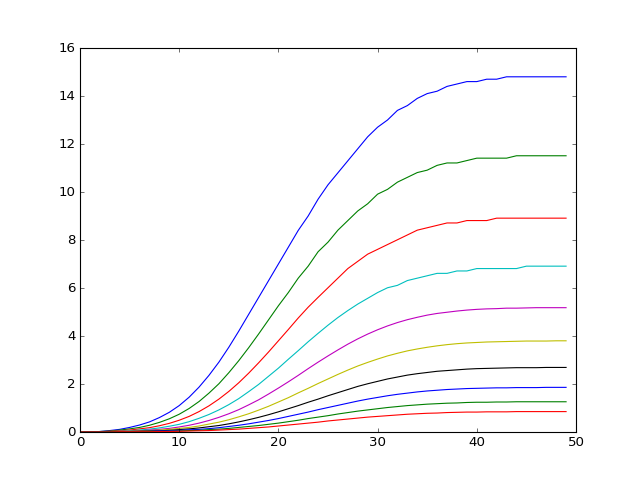

[[<matplotlib.lines.Line2D at 0x7f48ed123da0>],

In [28]:
[plt.plot(t) for t in temperatures]

Load VASP/AFF bragg peak data:

In [57]:
T_vasp, i200_vasp, i111_vasp = np.genfromtxt('VASP_Bragg_peaks.dat').T
vasp_ratios = (i200_vasp[0]/i111_vasp[0]) * i111_vasp/i200_vasp
from scipy.interpolate import interp1d
vasp_i_of_t = interp1d(T_vasp, vasp_ratios)

In [101]:
def vasp_aff_ratio(t_progression):
    ratio_progression = vasp_i_of_t(t_progression.loc[t_progression['Te'].between(vasp_i_of_t.x[0], vasp_i_of_t.x[-1])]).T
    return np.dot(ratio_progression, iframe)[0, 0]

Only use SCFLY datasets for which the maximum temperature is less than 5 eV (the max value in the VASP calculation)

In [143]:
intensities_good, progressions = zip(*[(intensity, p)
                                       for intensity, p
                                       in zip(intensities, temperatures)
                                       if np.array(p).T[0].max() < 5])

In [145]:
ratios_good = np.array([vasp_aff_ratio(p) for p in progressions])

<IPython.core.display.Javascript object>


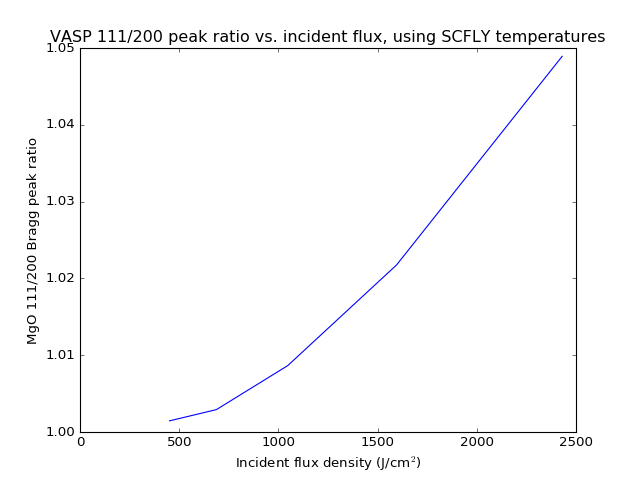

In [150]:
plt.title('VASP 111/200 peak ratio vs. incident flux, using SCFLY temperatures')
plt.xlabel('Incident flux density (J/cm$^2$)')
plt.ylabel('MgO 111/200 Bragg peak ratio')
plt.plot(intensities_good, ratios_good)

In [149]:
np.savetxt('scfly_vasp_progression.dat', [intensities_good, ratios_good])

### Now we calculate the Bragg peak ratio progression based on SCFLY's predicted charge state evolutions:

<IPython.core.display.Javascript object>


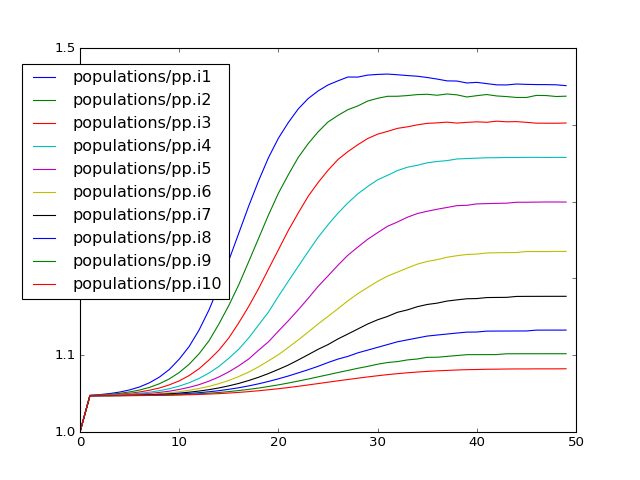

In [200]:
ratios = np.array([i111_ratio_from_population_file(p) for p in populations] )

<IPython.core.display.Javascript object>


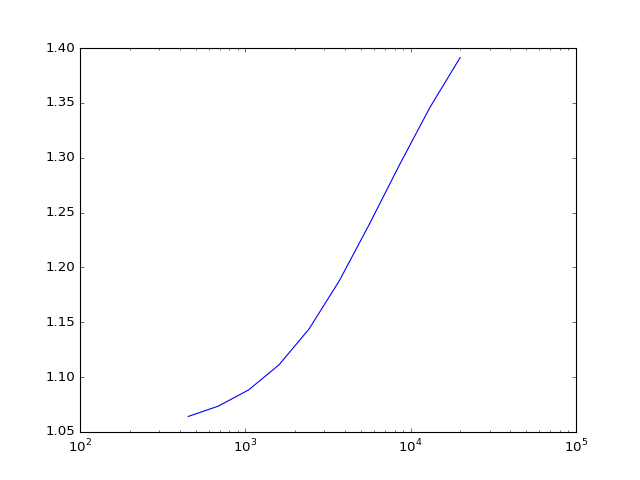

In [201]:
plt.semilogx()
plt.plot(intensities, ratios)

See MgO_ionization_plots.ipynb for plotting against experimental data:

In [202]:
np.savetxt('scfly_progression.dat', [intensities, ratios])

In [152]:
ls *dat

2d_progression.dat       ldos_O.dat@                 VASP_Bragg_peaks.dat
2d_progression_full.dat  populations.dat             vasp_progression.dat
intensity_grid.dat       scfly_progression.dat
ldos_Mg.dat@             scfly_vasp_progression.dat
